In [1]:
import numpy as np
import scipy.special as special

import matplotlib.pyplot as plt

In [2]:
## 1 atm in Pa
ps0 = 1.01325e5

In [3]:
def absorption(f, t=20, rh=60, ps=ps0):
    """ In dB/m
    
        f: frequency in Hz
        t: temperature in °C
        rh: relative humidity in %
        ps: atmospheric pressure in Pa

        From http://en.wikibooks.org/wiki/Engineering_Acoustics/Outdoor_Sound_Propagation
        See __main__ for actual curves.
    """
    
    if type(f) != int:
        f = f.reshape(1, len(f))
    if type(t) != int:
        t = t.reshape(len(t), 1)
    if type(rh) != int:
        rh = rh.reshape(len(rh), 1)
    T = t + 273.15
    T0 = 293.15
    T01 = 273.16

    Csat = -6.8346 * np.power(T01 / T, 1.261) + 4.6151
    rhosat = np.power(10, Csat)
    H = rhosat * rh * ps0 / ps

    frn = (ps / ps0) * np.power(T0 / T, 0.5) * (
            9 + 280 * H * np.exp(-4.17 * (np.power(T0 / T, 1/3.) - 1)))

    fro = (ps / ps0) * (24.0 + 4.04e4 * H * (0.02 + H) / (0.391 + H))

    alpha = f * f * (
        1.84e-11 / ( np.power(T0 / T, 0.5) * ps / ps0 )
        + np.power(T / T0, -2.5)
        * (
            0.10680 * np.exp(-3352 / T) * frn / (f * f + frn * frn)
            + 0.01278 * np.exp(-2239.1 / T) * fro / (f * f + fro * fro)
            )
        )

    return 20 * alpha / np.log(10)

In [4]:
j = 1j
### MEDIUM CONSTANTS
medium_density = 1204 # in g / m^3
speed_in_medium = 343 # m / s

### ASSUMING BAT GAPE HEIGHT OF 5-9MM IS PISTON DIAMETER
## a is piston radius
a = 0.003
bat_SPL_in_dB = 110
bat_frequency = 60000

### FIND THE WAVENUMBER GIVEN THE BAT FREQUENCY AND MOUTH APERTURE
wavelength = speed_in_medium / bat_frequency
k = 2*np.pi/wavelength
ka = k*a
medium = medium_density * speed_in_medium

### THE BAT FLIGHT SPEED DICTATES THE INCREMENT BETWEEN EACH X AND Y.
### This does not need to be the case. For now, we can choose a small increment
### And later select the points to simulate "if the bat was moving faster"
bat_flight_speed = 0.2
x = np.arange(-80, 80+bat_flight_speed, bat_flight_speed)
x = x.reshape(1, x.shape[0])
y = np.arange(80, -80-bat_flight_speed, -bat_flight_speed)
y = y.reshape(y.shape[0], 1)

### SET 0 VALUES TO 1E-3 SO WE AVOID DIVIDE-BY-ZERO ERROR
x_inds = np.where(np.isclose(x,0, atol=1e-4))
x[x_inds] = 1e-3
y_inds = np.where(np.isclose(y,0, atol=1e-4))
y[y_inds] = 1e-3

### SET Z AS 0 EVEN THOUGH WE DONT USE IT
z = 0

### CALCULATE THE RADIAL DISTANCE AND ANGLE THAT BAT IS TO MICROPHONE
r = np.sqrt((x**2) + (y**2))
theta = np.arctan(x/y)

### CHECK SHAPES
r.shape, theta.shape

((801, 801), (801, 801))

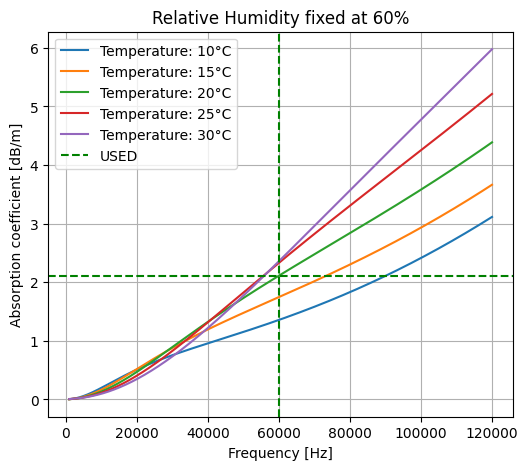

In [5]:
fs = np.linspace(int(1e3), int(1.2e5), int(1e3), endpoint=True)
t = np.arange(10, 35, 5)
t_labels = []
for temp in t:
    t_labels.append(f'Temperature: {temp}°C')
ys = absorption(fs, t=t)
plt.figure(figsize=(6, 5))
plt.rcParams.update({'font.size':10})
fs = fs * np.ones((len(t), 1))
plt.title('Relative Humidity fixed at 60%')
plt.plot(fs.T, ys.T, label=t_labels)
plt.axhline(y=absorption(bat_frequency), linestyle='dashed', color='g')
plt.axvline(x=bat_frequency, linestyle='dashed', color='g', label='USED')
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Absorption coefficient [dB/m]')
plt.legend()
plt.show()

![image](./20240622_model_setup.png)

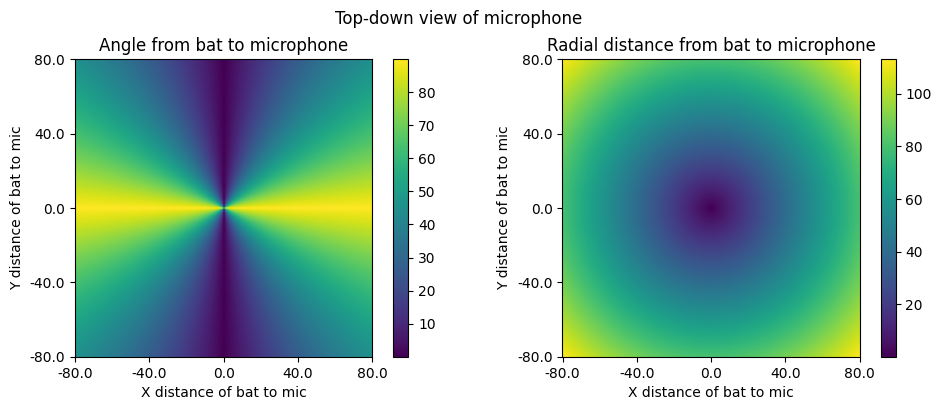

In [6]:
plt.figure(figsize=(10,4))

plt.suptitle('Top-down view of microphone')
plt.subplot(121)
plt.title('Angle from bat to microphone')
plt.imshow(np.abs(theta*(180/np.pi)))
step=int(40/bat_flight_speed)
plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
plt.ylabel('Y distance of bat to mic')
plt.xlabel('X distance of bat to mic')
plt.colorbar()

plt.subplot(122)
plt.title('Radial distance from bat to microphone')
plt.imshow(r)
step=int(40/bat_flight_speed)
plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
plt.ylabel('Y distance of bat to mic')
plt.xlabel('X distance of bat to mic')
plt.colorbar()

plt.tight_layout()
plt.show()

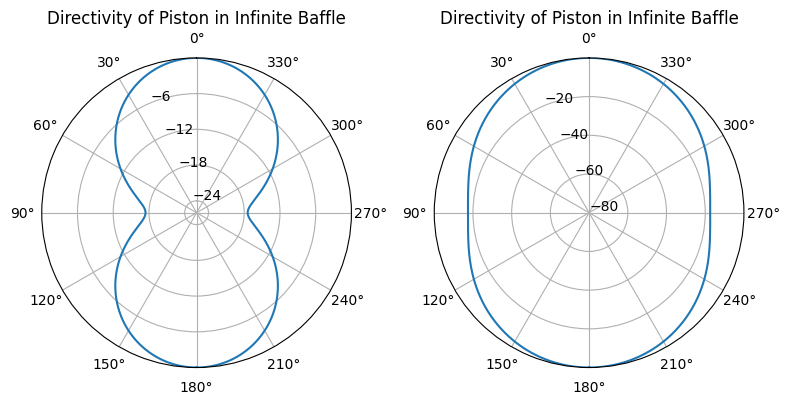

In [7]:
### Atmospheric attenuation found usinh Jakobsen at. al 2013
atmos_loss_DB = -1*absorption(bat_frequency)*r

### Directivity for piston in infinite baffle using Beranek et. al 2019
D_theta = 2*special.j1(ka*np.sin(theta))/(ka*np.sin(theta))
D_theta_dB = 20*np.log10(np.abs(D_theta))
clipped_D_theta_dB = np.clip(D_theta_dB, -24, None)

### Geometric Spreading calculated using Jakobsen et. al 2013
spreading_dB = 20*np.log10(r)


theta_polar = np.linspace(-np.pi, np.pi, 1000)
theta_polar = theta_polar.reshape(theta_polar.shape[0], 1)
D_theta_polar = 2*special.j1(ka*np.sin(theta_polar))/(ka*np.sin(theta_polar))
D_theta_polar_dB = 20*np.log10(np.abs(D_theta_polar))
clipped_D_theta_polar_dB = np.clip(D_theta_polar_dB, -24, None)


fig = plt.figure(figsize=(8, 4))
a0 = fig.add_subplot(121, projection='polar')
a0.set_title(f"Directivity of Piston in Infinite Baffle")
a0.plot(theta_polar, clipped_D_theta_polar_dB)
a0.set_xticks(np.arange(0,2*np.pi,np.pi/6))
a0.set_yticks(np.arange(-24,0,6))
a0.set_ylim(-26, 0)
a0.set_theta_zero_location('N')

a1 = fig.add_subplot(122, projection='polar')
a1.set_title(f"Directivity of Piston in Infinite Baffle")
a1.plot(theta_polar, D_theta_polar_dB)
a1.set_xticks(np.arange(0,2*np.pi,np.pi/6))
a1.set_yticks(np.arange(-80,0,20))
a1.set_theta_zero_location('N')

plt.tight_layout()
plt.show()

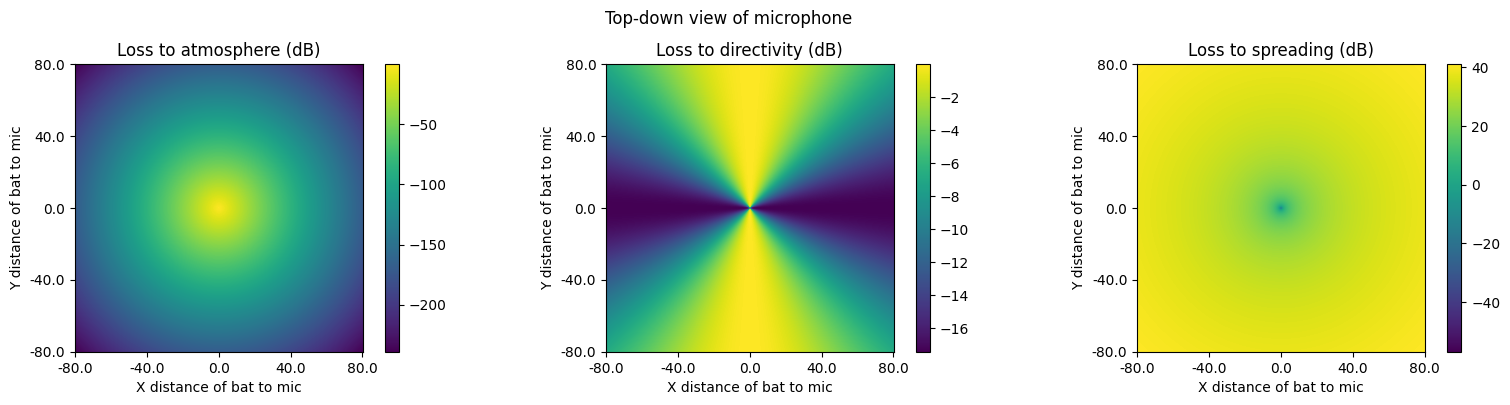

In [8]:
plt.figure(figsize=(16,4))

plt.suptitle('Top-down view of microphone')
plt.subplot(131)
plt.title('Loss to atmosphere (dB)')
plt.imshow(atmos_loss_DB)
plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
plt.ylabel('Y distance of bat to mic')
plt.xlabel('X distance of bat to mic')
plt.colorbar()

plt.subplot(132)
plt.title('Loss to directivity (dB)')
plt.imshow(D_theta_dB)
plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
plt.ylabel('Y distance of bat to mic')
plt.xlabel('X distance of bat to mic')
plt.colorbar()

plt.subplot(133)
plt.title('Loss to spreading (dB)')
plt.imshow(spreading_dB)
plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
plt.ylabel('Y distance of bat to mic')
plt.xlabel('X distance of bat to mic')
plt.colorbar()

plt.tight_layout()
plt.show()

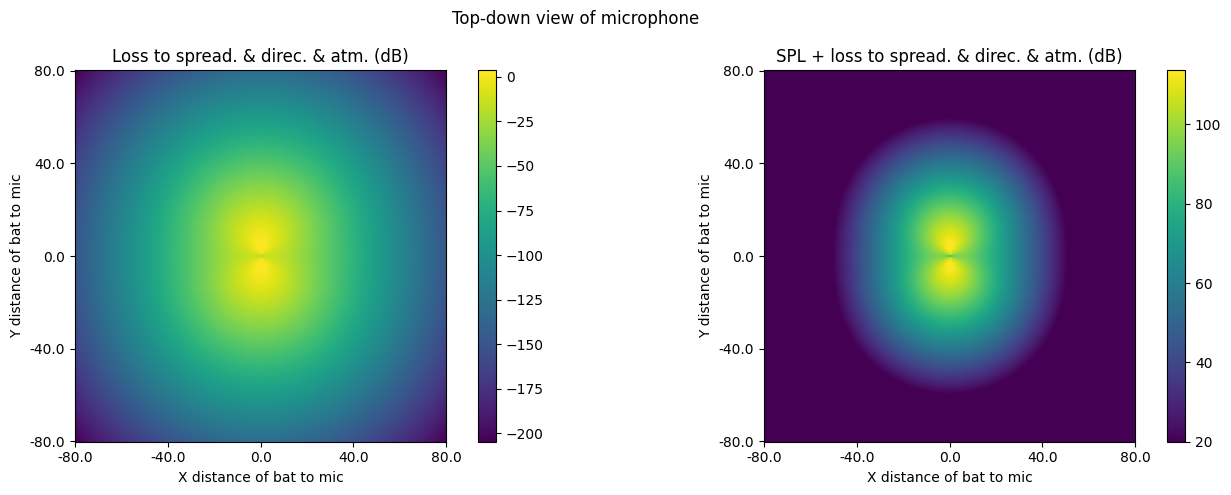

In [9]:
TL_dB = spreading_dB+D_theta_dB+atmos_loss_DB ### Frequency-dependent transmission loss!

RL_dB = TL_dB+bat_SPL_in_dB ### Receiver loss!
clipped_RL_dB = np.clip(RL_dB, 20, None)

plt.figure(figsize=(14,5))

plt.suptitle('Top-down view of microphone')
plt.subplot(121)
plt.title('Loss to spread. & direc. & atm. (dB)')
plt.imshow(TL_dB)
plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
plt.ylabel('Y distance of bat to mic')
plt.xlabel('X distance of bat to mic')
plt.colorbar()

plt.subplot(122)
plt.title('SPL + loss to spread. & direc. & atm. (dB)')
plt.imshow(clipped_RL_dB)
plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
plt.ylabel('Y distance of bat to mic')
plt.xlabel('X distance of bat to mic')
plt.colorbar()

plt.tight_layout()
plt.show()